In [109]:
import os

from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3

from yaml import load
from yaml import SafeLoader
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage
import json

from typing import Annotated, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from openai import OpenAI
from typing_extensions import TypedDict
import openai
os.environ["OPENAI_API_KEY"] = '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'

In [110]:
import re
def contains_valid_word(response_text):

  pattern = r'\bVALID\b' 
  if re.search(pattern, response_text):
    return True
  else:
    return False

In [111]:
INITIAL_PROMPT = """
You are a professional fitness coach.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weight and height

WEGHIT:{weight}
HEIGHT:{tall}
GOAL:{goal}
intensity:{intensity}
age:{age}
sex:{sex}
Equipment: local gym
 don't have two or more exercises for the same primary and secondary muscles
 
 Prioritize variety and muscle group balance

** Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
   search one primary muscle group and one sub-muscle group at a time.

IMPORTANT:
   - Back: exactly 5 exercises
   - Chest: exactly 5 exercises
   - Shoulders: exactly 5 exercises
   - Arms: exactly 6 exercises
   - Legs: exactly 6 exercises
   - Core: exactly 2 exercises
   
** Output the full program in a clean, structured format that includes:
   - Exercises with primary/secondary muscle groups
   - Instructions, sets, reps, and variations
   - the plan is 5 days long


NOTIFIY THE USER how many exercises THE DATABASE RETURNED  THE CORRECT ANSWER and how many NO ANSWER.
and 2 for core 
make sure that primary muscle and sub muscle you search are in this massage list


"""

In [112]:
JUDGE_PROMPT = """
You are a fitness program evaluator. Your task is to assess the quality, accuracy, and completeness of a workout program.
Evaluate the following workout plan according to these criteria:


1. **Exercise Count Validation**:
   - Back: exactly 5 exercises
   - Chest: exactly 5 exercises
   - Shoulders: exactly 5 exercises
   - Arms: exactly 6 exercises
   - Legs: exactly 6 exercises
   - Core: exactly 2 exercises

2. **Muscle Group Coverage**:
   - Ensure each listed body part targets both **primary** and **secondary** muscle groups.
   - Verify that **lower back** is included as a target at least once, preferably on Back or Legs day.

3. **Variety & Movement Pattern Check**:
   - Ensure that there is **no repetition of the same movement pattern** (e.g., multiple types of horizontal rows or vertical presses) within a single muscle group day.
   - Confirm **variety in exercises** to promote balanced muscle development.

4. **Format Consistency**:
   - Each exercise must include: **name**, **primary muscles**, **secondary muscles**, **sets**, and **reps**.
   - Plan must be clean, structured, and easy to read.

5. **Feedback on Plan**:
   - If all criteria are met: respond with `"VALID PLAN"` otherwise dont say Valid.
   - If criteria are not met: respond with `"INVALID PLAN"` and clearly explain **which criteria were violated** and how to fix them. 
   - Be as concise and clear as possible
Review the plan below and return your evaluation:
===
{plan}
===
"""


In [113]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()

In [114]:
config = load(open("config.yaml"), Loader=SafeLoader)
os.environ["GROQ_API_KEY"] = config["groq"]["apiKey"]
from langchain_groq import ChatGroq


In [ ]:
from langchain.tools import tool
connection = sqlite3.connect("work_out.db")
@tool
def get_exercises(body_part: str, primary_muscles: str, secondary_muscles: str,exercises_number:int=2) -> list:
    """
    Fetches exercises from the SQLite database based on primary and sub muscle.

    Args:
        body_part (str): The body part to filter exercises by Body parts: Back, Chest, Leg, Shoulders, Arms.
        primary_muscles (str): Primary muscle group targeted.
        secondary_muscle (str): Secondary muscle group targeted.
        exercises_number (int): Number of exercises to fetch (default is 2) change if you need more results.
    
    Returns:
        str: A formatted string listing matching exercises, one per line.
    """
    primary_muscles = primary_muscles.lower().strip()
    secondary_muscles = secondary_muscles.lower().strip()
    body_part = body_part.lower().strip()
    body_part_modified = body_part[:-1] if body_part.endswith('s') else body_part

    connection = sqlite3.connect("work_out.db")
    cursor = connection.cursor()
    query = f"""
        SELECT exercise,primary_muscles,secondary_muscles 
        FROM DATASET
        WHERE (primary_muscles LIKE '%{primary_muscles}%' 
               and secondary_muscles LIKE '%{secondary_muscles}%')
        AND body_part = '{body_part_modified}'
        LIMIT {exercises_number};
    """
    parameters = (f"%{primary_muscles}%", f"%{secondary_muscles}%", body_part_modified)
    cursor.execute(query)
    rows = cursor.fetchall()
    connection.close()
    if not rows:
        return "no exercises found"
    exercise_details = []
    for i, (name, prim, sec) in enumerate(rows, 1):
        name_str = str(name).strip() if name else "Unknown Exercise"
        prim_str = str(prim).strip() if prim else "N/A"
        sec_str = str(sec).strip() if sec else "N/A" 
        exercise_details.append(
            f"{i}. {name_str}\n   Primary: {prim_str}\n   Secondary: {sec_str}"
        )
    formatted_output = "\n ".join(exercise_details)
    return f"Found these exercises:\n{formatted_output}"
    
    


In [116]:
tools=[get_exercises]

In [117]:

llm_plan = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm_judge = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
llm_judge=llm_plan
llm=llm_plan.bind_tools(tools)

In [118]:
tool_node=ToolNode(tools)

In [119]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    jude: Annotated[list,add_messages]
    summary_plan: str

In [120]:
openai_client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  
)

In [121]:
llm2=ChatOpenAI(model="meta-llama/llama-4-maverick:free",base_url="https://openrouter.ai/api/v1")



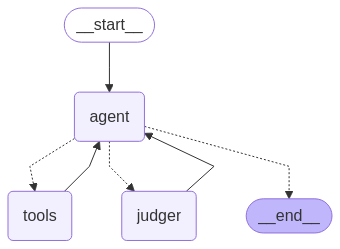

In [122]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    judge: str
    summary_plan: str
    
def should_continue(state: State) -> Literal["tools", "judger",END]:  # Changed "summary" to "end"
    messages = state["messages"]
    last_message = messages[-1]
    
    # Only continue to tools if there are active tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    if "judge" in state and contains_valid_word(state["judge"]):
        return END
    else:
        return "judger"


def call_model(state: State):
    #always send the last 5 messages to the model
    print("you are in call model ")
    messages = state["messages"]
    for i, msg in enumerate(messages):
        if isinstance(msg, ToolMessage) and not isinstance(msg.content, str):
            messages[i] = ToolMessage(
                tool_call_id=msg.tool_call_id,
                content=json.dumps(msg.content)
            )
    messages=messages[-10:]
    response = llm.invoke(messages)
    return {"messages": [response]}

def summary_node(state: State):
    print("you are in summary ")
    messages = state["messages"]
    messages.append( summary_prompt)
    summarize =llm.invoke(messages)
    print("you are near end ")

    return {
        "messages": messages,
        "summary_plan": summarize,
    }
def call_judge(state:State):
    lastmessage = state["messages"][-1]
    prompt=JUDGE_PROMPT.format(plan=lastmessage)
    response=llm_pure.invoke(prompt)
    print("**********************************************************************")
    
    new_message = HumanMessage(content=response.content)
    return {
        "messages": new_message,
          "judge": response.content
      }
workflow = StateGraph(State)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("judger", call_judge)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("judger", "agent")

workflow.add_edge("tools", "agent")
#workflow.add_edge("summary", END)
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [123]:
INITIAL_PROMPT=INITIAL_PROMPT.format(weight=90, tall=180,goal="get lean muscle",sex="male",age=25,intensity="high")

In [124]:
config = {
    "recursion_limit": 70,
    "configurable": {
        "thread_id": 78,}}

In [125]:
inputs = {"messages": [("user", INITIAL_PROMPT)]}
print_stream(graph.stream(inputs, config, stream_mode="values"))
# Start chatbot


================================ Human Message =================================


You are a professional fitness coach.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weight and height

WEGHIT:90
HEIGHT:180
GOAL:get lean muscle
intensity:high
age:25
sex:male
Equipment: local gym
 don't have two or more exercises for the same primary and secondary muscles
 
 Prioritize variety and muscle group balance

** Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
   search one primary muscle group and one sub-muscle group at a time.

IMPORTANT:
   - Back: exactly 5 exercises
   - Chest: exactly 5 exercises
   - Shoulders: exactly 5 exercises
   - Arms: exactly 6 exercises
   - Legs: exactly 6 exercises
   - Core: exactly 2 exercises
   
** Output the full program in a clean, structured format that includes:
   - Exercises with pri

InternalServerError: Error code: 500 - {'error': {'message': 'Internal Server Error', 'type': 'internal_server_error'}}

In [ ]:
intr

In [ ]:
inputs = {"messages": [("user", "what are the back exercises in this plan ?")] }
print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================

what is the back exercises in this plan ?
you are in call model 
================================== Ai Message ==================================

The back exercises in this plan are:

1. Bent-Over Barbell Rows (Day2: Back and Biceps)
	* Primary: Latissimus Dorsi, Rhomboids, Trapezius, Lower Back, Middle Back
	* Secondary: Abs, Biceps, Forearms, Upper Back
2. Pull-Ups (Day2: Back and Biceps)
	* Primary: Latissimus Dorsi
	* Secondary: Biceps, Trapezius, Rhomboids, Shoulders, Forearms
3. Lat Pulldowns (Day2: Back and Biceps)
	* Primary: Latissimus Dorsi
	* Secondary: Biceps, Rhomboids, Trapezius
4. Deadlifts (Day3: Legs)
	* Primary: Hamstrings, Glutes, Lower Back
	* Secondary: Quadriceps, Core, Trapezius, Rhomboids

These exercises target the major muscle groups of the back, including the latissimus dorsi, trapezius, rhomboids, and lower back muscles.


In [ ]:
response=get_exercises.invoke({"body_part": "Arm", "primary_muscles": "Triceps ", "secondary_muscles": "Forearm "})

formatted = response.replace("\\n", "\n")
print(formatted)


Found these exercises:
1. Incline Dumbbell Curl
   Primary: ['Biceps Brachii']
   Secondary: ['Brachialis', 'Forearm muscles', 'Brachioradialis']
 2. Concentration Curl
   Primary: ['Biceps Brachii']
   Secondary: ['Brachialis', 'Brachioradialis', 'Forearm']
 3. Reverse Curl (Barbell or Dumbbell)
   Primary: ['Biceps Brachii', 'Brachialis', 'Brachioradialis']
   Secondary: ['Forearm Flexors', 'Triceps']
 4. EZ Bar Curl
   Primary: ['Biceps Brachii']
   Secondary: ['Brachialis', 'Brachioradialis', 'Forearms']
 5. Zottman Curl
   Primary: ['Biceps brachii']
   Secondary: ['Brachialis', 'Brachioradialis', 'Forearm flexors and extensors']


In [ ]:
Interrupt


NameError: name 'Interrupt' is not defined

In [ ]:
latexcode=""" **Day1: Chest and Triceps**

1. Barbell Bench Press
* Primary: Pectoralis Major
* Secondary: Anterior Deltoids, Triceps
* Sets:4
* Reps:8-12
2. Incline Dumbbell Press
* Primary: Upper Pectoralis Major
* Secondary: Anterior Deltoids, Triceps
* Sets:3
* Reps:10-15
3. Triceps Rope Pushdown
* Primary: Triceps Brachii
* Secondary: none
* Sets:3
* Reps:12-15
4. Skull Crushers
* Primary: Triceps Brachii
* Secondary: none
* Sets:3
* Reps:8-12
5. Triceps Dips
* Primary: Triceps Brachii
* Secondary: Shoulders
* Sets:3
* Reps:12-15

**Day2: Back and Biceps**

1. Bent-Over Barbell Rows
* Primary: Latissimus Dorsi, Rhomboids, Trapezius, Lower Back, Middle Back
* Secondary: Abs, Biceps, Forearms, Upper Back
* Sets:4
* Reps:8-12
2. Pull-Ups
* Primary: Latissimus Dorsi
* Secondary: Biceps, Trapezius, Rhomboids, Shoulders, Forearms
* Sets:3
* Reps:8-12
3. Lat Pulldowns
* Primary: Latissimus Dorsi
* Secondary: Biceps, Rhomboids, Trapezius
* Sets:3
* Reps:10-12
4. Dumbbell Bicep Curl
* Primary: Biceps Brachii
* Secondary: Brachialis, Brachioradialis
* Sets:3
* Reps:10-15

**Day3: Legs**

1. Back Squat
* Primary: Quadriceps, Hamstrings, Glutes
* Secondary: Back, Core, Shoulders, Arms
* Sets:4
* Reps:8-12
2. Deadlifts
* Primary: Hamstrings, Glutes, Lower Back
* Secondary: Quadriceps, Core, Trapezius, Rhomboids
* Sets:3
* Reps:8-12
3. Bulgarian Split Squat
* Primary: Quadriceps, Glutes, Hamstrings
* Secondary: Hip Flexors
* Sets:3
* Reps:10-15 per leg
4. Leg Extension
* Primary: Quadriceps
* Secondary: none
* Sets:3
* Reps:12-15
5. Leg Curl
* Primary: Hamstrings
* Secondary: none
* Sets:3
* Reps:10-15
6. Calf Raise
* Primary: Gastrocnemius, Soleus
* Secondary: none
* Sets:3
* Reps:12-15

**Day4: Shoulders and Abs**

1. Standing Military Press
* Primary: Deltoids
* Secondary: Triceps, Core
* Sets:4
* Reps:8-12
2. Front Raises
* Primary: Anterior Deltoids
* Secondary: none
* Sets:3
* Reps:10-15
3. Lateral Raises
* Primary: Deltoids
* Secondary: Trapezius, Shoulders
* Sets:3
* Reps:12-15
4. Reverse Fly
* Primary: Rear Deltoids
* Secondary: Trapezius, Rhomboids
* Sets:3
* Reps:12-15
5. Russian Twists
* Primary: Obliques
* Secondary: Core
* Sets:3
* Reps:12-15 per side
6. Plank
* Primary: Core
* Secondary: Shoulders, Back
* Sets:3
* Hold:30-60 seconds

**Day5: Arms**

1. Triceps Kickback
* Primary: Triceps Brachii
* Secondary: none
* Sets:3
* Reps:12-15
2. Close-Grip Bench Press
* Primary: Triceps Brachii
* Secondary: Chest, Shoulders
* Sets:3
* Reps:8-12
3. Hammer Curl
* Primary: Biceps Brachii, Brachialis
* Secondary: Brachioradialis, Forearm muscles
* Sets:3
* Reps:10-15
4. Preacher Curl
* Primary: Biceps Brachii
* Secondary: Brachialis
* Sets:3
* Reps:10-15
5. Incline Dumbbell Curl
* Primary: Biceps Brachii
* Secondary: Brachialis, Brachioradialis
* Sets:3
* Reps:10-15"""

In [ ]:
latex_code=llm_pure.invoke(latexcode+"turn this into latex")

In [ ]:
latex_code.content

'Here is the workout plan in LaTeX format:\n\n```latex\n\\documentclass{article}\n\\usepackage[margin=1in]{geometry}\n\\usepackage{enumitem}\n\n\\begin{document}\n\n\\section*{Workout Plan}\n\nThe following is a 5-day workout plan, targeting different muscle groups each day.\n\n\\subsection*{Day 1: Chest and Triceps}\n\n\\begin{enumerate}[label=\\arabic*.]\n    \\item \\textbf{Barbell Bench Press}\n    \\begin{itemize}\n        \\item Primary: Pectoralis Major\n        \\item Secondary: Anterior Deltoids, Triceps\n        \\item Sets: 4\n        \\item Reps: 8-12\n    \\end{itemize}\n    \\item \\textbf{Incline Dumbbell Press}\n    \\begin{itemize}\n        \\item Primary: Upper Pectoralis Major\n        \\item Secondary: Anterior Deltoids, Triceps\n        \\item Sets: 3\n        \\item Reps: 10-15\n    \\end{itemize}\n    \\item \\textbf{Triceps Rope Pushdown}\n    \\begin{itemize}\n        \\item Primary: Triceps Brachii\n        \\item Secondary: none\n        \\item Sets: 3\n     

In [ ]:
inputs = {"messages": [("user", "what are the leg exercises in this plan ?")] }
print_stream(graph.stream(inputs, config, stream_mode="values"))
# Start chatbot 



================================ Human Message =================================

what are the leg exercises in this plan ?
you are in call model 
================================== Ai Message ==================================

The leg exercises in this plan are:

1. **Squats** (Day3)
 - Primary: Quadriceps, Hamstrings, Glutes
 - Secondary: Back, Core, Shoulders
2. **Leg Press** (Day3)
 - Primary: Quadriceps, Hamstrings, Glutes
 - Secondary: Calf Muscles
3. **Lunges** (Day3)
 - Primary: Quadriceps, Hamstrings, Glutes
 - Secondary: Core
4. **Leg Extensions** (Day3)
 - Primary: Quadriceps
 - Secondary: None
5. **Leg Curls** (Day3)
 - Primary: Hamstrings
 - Secondary: None
6. **Deadlifts** (Day5)
 - Primary: Hamstrings, Glutes, Lower Back
 - Secondary: Quadriceps, Core, Trapezius

These exercises target the major muscle groups in the legs, including quadriceps, hamstrings, and glutes.


In [ ]:
latex_code=llm.invoke()

TypeError: RunnableBindingBase.invoke() missing 1 required positional argument: 'input'

In [ ]:
latex_code.content

'```latex\ndocumentclass{article}\nusepackage[margin=1in]{geometry}\nusepackage{enumitem}\n\nbegin{document}\n\nsection*{5-Day Workout Plan for Getting Lean Muscle}\n\nsubsection*{Day1: Chest and Triceps}\n\nbegin{enumerate}[label=arabic*.]\n item textbf{Barbell Bench Press}\n begin{itemize}\n item Primary: Pectoralis Major\n item Secondary: Anterior Deltoids, Triceps\n item Sets:4\n item Reps:8-12\n end{itemize}\n item textbf{Incline Dumbbell Press}\n begin{itemize}\n item Primary: Upper Pectoralis Major\n item Secondary: Anterior Deltoids, Triceps\n item Sets:3\n item Reps:10-12\n end{itemize}\n item textbf{Triceps Pushdown}\n begin{itemize}\n item Primary: Triceps Brachii\n item Secondary: None\n item Sets:3\n item Reps:12-15\n end{itemize}\n item textbf{Overhead Dumbbell Extension}\n begin{itemize}\n item Primary: Triceps Brachii\n item Secondary: None\n item Sets:3\n item Reps:12-15\n end{itemize}\nend{enumerate}\n\nsubsection*{Day2: Back and Biceps}\n\nbegin{enumerate}[label=arab

In [ ]:
import subprocess
import os

latex_code = r"""\documentclass{article}
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{amssymb}
\usepackage{geometry}
\geometry{a4paper, margin=1in}
\begin{document}

\section*{5-Day Workout Plan}

\subsection*{Day 1: Chest and Triceps}
\begin{enumerate}
    \item \textbf{Barbell Bench Press}
    \begin{itemize}
        \item Primary: Pectoralis Major
        \item Secondary: Anterior Deltoids, Triceps
        \item Sets: 4
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Incline Dumbbell Press}
    \begin{itemize}
        \item Primary: Upper Pectoralis Major
        \item Secondary: Anterior Deltoids, Triceps
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
    \item \textbf{Triceps Rope Pushdown}
    \begin{itemize}
        \item Primary: Triceps Brachii
        \item Secondary: none
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
    \item \textbf{Skull Crushers}
    \begin{itemize}
        \item Primary: Triceps Brachii
        \item Secondary: none
        \item Sets: 3
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Triceps Dips}
    \begin{itemize}
        \item Primary: Triceps Brachii
        \item Secondary: Shoulders
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
\end{enumerate}

\subsection*{Day 2: Back and Biceps}
\begin{enumerate}
    \item \textbf{Bent-Over Barbell Rows}
    \begin{itemize}
        \item Primary: Latissimus Dorsi, Rhomboids, Trapezius, Lower Back, Middle Back
        \item Secondary: Abs, Biceps, Forearms, Upper Back
        \item Sets: 4
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Pull-Ups}
    \begin{itemize}
        \item Primary: Latissimus Dorsi
        \item Secondary: Biceps, Trapezius, Rhomboids, Shoulders, Forearms
        \item Sets: 3
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Lat Pulldowns}
    \begin{itemize}
        \item Primary: Latissimus Dorsi
        \item Secondary: Biceps, Rhomboids, Trapezius
        \item Sets: 3
        \item Reps: 10-12
    \end{itemize}
    \item \textbf{Dumbbell Bicep Curl}
    \begin{itemize}
        \item Primary: Biceps Brachii
        \item Secondary: Brachialis, Brachioradialis
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
\end{enumerate}

\subsection*{Day 3: Legs}
\begin{enumerate}
    \item \textbf{Back Squat}
    \begin{itemize}
        \item Primary: Quadriceps, Hamstrings, Glutes
        \item Secondary: Back, Core, Shoulders, Arms
        \item Sets: 4
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Deadlifts}
    \begin{itemize}
        \item Primary: Hamstrings, Glutes, Lower Back
        \item Secondary: Quadriceps, Core, Trapezius, Rhomboids
        \item Sets: 3
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Bulgarian Split Squat}
    \begin{itemize}
        \item Primary: Quadriceps, Glutes, Hamstrings
        \item Secondary: Hip Flexors
        \item Sets: 3
        \item Reps: 10-15 per leg
    \end{itemize}
    \item \textbf{Leg Extension}
    \begin{itemize}
        \item Primary: Quadriceps
        \item Secondary: none
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
    \item \textbf{Leg Curl}
    \begin{itemize}
        \item Primary: Hamstrings
        \item Secondary: none
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
    \item \textbf{Calf Raise}
    \begin{itemize}
        \item Primary: Gastrocnemius, Soleus
        \item Secondary: none
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
\end{enumerate}

\subsection*{Day 4: Shoulders and Abs}
\begin{enumerate}
    \item \textbf{Standing Military Press}
    \begin{itemize}
        \item Primary: Deltoids
        \item Secondary: Triceps, Core
        \item Sets: 4
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Front Raises}
    \begin{itemize}
        \item Primary: Anterior Deltoids
        \item Secondary: none
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
    \item \textbf{Lateral Raises}
    \begin{itemize}
        \item Primary: Deltoids
        \item Secondary: Trapezius, Shoulders
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
    \item \textbf{Reverse Fly}
    \begin{itemize}
        \item Primary: Rear Deltoids
        \item Secondary: Trapezius, Rhomboids
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
    \item \textbf{Russian Twists}
    \begin{itemize}
        \item Primary: Obliques
        \item Secondary: Core
        \item Sets: 3
        \item Reps: 12-15 per side
    \end{itemize}
    \item \textbf{Plank}
    \begin{itemize}
        \item Primary: Core
        \item Secondary: Shoulders, Back
        \item Sets: 3
        \item Hold: 30-60 seconds
    \end{itemize}
\end{enumerate}

\subsection*{Day 5: Arms}
\begin{enumerate}
    \item \textbf{Triceps Kickback}
    \begin{itemize}
        \item Primary: Triceps Brachii
        \item Secondary: none
        \item Sets: 3
        \item Reps: 12-15
    \end{itemize}
    \item \textbf{Close-Grip Bench Press}
    \begin{itemize}
        \item Primary: Triceps Brachii
        \item Secondary: Chest, Shoulders
        \item Sets: 3
        \item Reps: 8-12
    \end{itemize}
    \item \textbf{Hammer Curl}
    \begin{itemize}
        \item Primary: Biceps Brachii, Brachialis
        \item Secondary: Brachioradialis, Forearm muscles
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
    \item \textbf{Preacher Curl}
    \begin{itemize}
        \item Primary: Biceps Brachii
        \item Secondary: Brachialis
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
    \item \textbf{Incline Dumbbell Curl}
    \begin{itemize}
        \item Primary: Biceps Brachii
        \item Secondary: Brachialis, Brachioradialis
        \item Sets: 3
        \item Reps: 10-15
    \end{itemize}
\end{enumerate}

\end{document}
"""
with open("output2.tex", "w", encoding="utf-8") as f:
    f.write(latex_code)
pdflatex_path = r"C:\Users\Hossa\AppData\Local\Programs\MiKTeX\miktex\bin\x64\pdflatex.exe"
try:
  
    print("Compiling LaTeX file...")
    result = subprocess.run([pdflatex_path, "output2.tex"], cwd=os.getcwd(), check=True, capture_output=True, text=True)
    print("LaTeX compilation successful.")
    print("pdflatex output:")
    print(result.stdout)
    if result.stderr:
        print("pdflatex errors/warnings:")
        print(result.stderr)

except FileNotFoundError:
    print(f"Error: pdflatex executable not found at '{pdflatex_path}'. Please check the path.")
except subprocess.CalledProcessError as e:
    print(f"Error during LaTeX compilation: {e}")
    print("pdflatex output:")
    print(e.stdout)
    print("pdflatex errors/warnings:")
    print(e.stderr)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Compiling LaTeX file...
LaTeX compilation successful.
pdflatex output:
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (MiKTeX 24.1) (preloaded format=pdflatex.fmt)
 restricted \write18 enabled.
entering extended mode
(output2.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-04>
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\Hossa\AppData\Local\Programs\Mi

In [ ]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [ ]:
class single_exercise(BaseModel):
    exercise: str = Field(description="exercise name")
    sub_muscles: list [str] = Field(description="list of sub_muscle in this exercise")
    primary_muscles:list [ str] = Field(description="list of primary muscle in this exercise")
    sets :str = Field(description="number of sets")
    reps: str = Field(description="number of reps")
    instruction: str = Field(description="exercise instruction")
    @property
    def summary(self):
        return f"sub_muscle: {self.sub_muscle}, exercise: {self.exercise}, sets: {self.sets}, reps: {self.reps}, details: {self.details}"
class single_body_part(BaseModel):
    body_part: str = Field(description="name of the body part")
    exercises: List[single_exercise] = Field(description="list of exercises in this body part")
    @property
    def summary(self):
        return f"body_part: {self.body_part}, exercises: {self.exercises}"
#structed_output_llm=llm.with_structured_output(single_body_part)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# Define the prompt template with proper input variables
fitness_instructions = ChatPromptTemplate.from_template("""
You are tasked with generating a list of exercises for {body_part} that the user needs to train. Follow these instructions carefully:

1. First, review the Goal: {Goal} and the height and weight of {tall}cm and {weight}kg then specify the level of {the_level_of_cardio}.
    
2. Examine any editorial feedback: {human_feedback}

3. Take notes on the level of {intensity}

4. You can search the database for exercises by using tools

{input}
{agent_scratchpad}""")  # Required for tool calling

# Construct the tool calling agent
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=fitness_instructions
)

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,max_iterations=3)

response = agent_executor.invoke({
    "body_part": "back",
    "Goal": "gain muscle",
    "intensity": "moderate",
    "tall": 180,
    "weight": 70,
    "the_level_of_cardio": "medium",
    "human_feedback": "",
    "input": "Generate workout exercises for back",
})



> Entering new AgentExecutor chain...

Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']

> Finished chain.


In [ ]:
response

{'body_part': 'back',
 'Goal': 'gain muscle',
 'intensity': 'moderate',
 'tall': 180,
 'weight': 70,
 'the_level_of_cardio': 'medium',
 'human_feedback': '',
 'input': 'Generate workout exercises for back',
 'output': 'Agent stopped due to max iterations.'}

In [ ]:
class Generate_plans(TypedDict):
    goal:str # goal of the workout_plans
    intensity: str # intensity of the workout
    tall: int 
    weight: int
    human_feedback: str
    max_exercises: int
    muscle_workouts: List[MainMuscle] # list of whole body exercise

In [ ]:
import langchain_core

In [ ]:
fitness_instructions="""You are tasked with retreiving and review a set of exercises for each muscle group. Follow these instructions carefully:

1. First, review the research topic:
{goal}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. Assign one set of exercises to each main muscle group.
5. Pick the top {max_exercises} exercises for each SUB muscle group."""


In [ ]:
def create_plans(state: Generate_plans):
    
    """ Create plans """
    print("i am here")
    goal=state.get('goal', '')
    intensity=state.get('intensity', '')
    human_feedback=state.get('human_feedback', '')
    max_exercises=state.get('max_exercises', 0)    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = fitness_instructions.format(goal=goal,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,max_exercises=max_exercises)

    # Generate question 
    main_muscle_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="serach the set of exercises with serach_by_sub_muscle_tool and enhance it.")])
    
    # Write the list of analysis to state
    return {"muscle_workouts": main_muscle_plans}

In [ ]:
def search_exercises(main: str = None, sub: str = None):
    cursor = connection.cursor()
    cursor.execute(
        """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
        """,
        (f"%{sub}%", f"%{main}%")
    )
    rows = cursor.fetchall()
    print("I am here")
    # Display the results
    return rows


In [ ]:
def human_feedback_nod(state: Generate_plans):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: Generate_plans):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(Generate_plans)
builder.add_node("create_plans", create_plans)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

NameError: name 'Generate_plans' is not defined

In [ ]:
# Input
max_exercises = 2
goal = "lose weight"
intessity = "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"goal":goal,"max_exercises":max_exercises,"instensity":intessity}, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here
('muscle_workouts', [{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])


In [ ]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_exercises': 2, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb9e79-7665-6672-8001-cbe35fa2ccc6'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'mus